In [1]:
from src.bounds import *
import torch
from dataclasses import dataclass
import numpy as np
from src.utils import predict
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

In [2]:
save_root = "../data/civil_comments/"
X = torch.load(save_root+"X_train.pt")
y = torch.load(save_root+"y_train.pt")
g = torch.load(save_root+"g_train.pt")

In [3]:
@dataclass
class Split:
    X: torch.Tensor
    g: torch.Tensor
    
    
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) and len(b) == len(c)
    p = torch.randperm(a.size()[0])
    return a[p], b[p], c[p]

In [4]:
var_key = ["male", "female", "black", "white"]
interest_vars = [("male","black"),("female","black"),("male","white"),("female","white")]

In [5]:
n_val = 50000
delta = 0.05
num_hypotheses = 100
no_groups = len(interest_vars)
correction = delta/(num_hypotheses*(no_groups))

In [6]:
thresholds = torch.linspace(0.5, 3.0, num_hypotheses)

In [7]:
def calibrator(probs, thresholds, eps=1e-6):
    probs = probs.unsqueeze(1)
    x = np.array(probs, dtype=np.float64)
    x = np.clip(x, eps, 1 - eps)
    x = np.log(x / (1 - x))
    print("before", x.shape)
    x = x * np.array(thresholds)
    print("after", x.shape)
    output = 1 / (1 + np.exp(-x))
    return output

In [8]:
preds = calibrator(X, thresholds)

before (269038, 1)
after (269038, 100)


In [9]:
preds.shape, preds[:,0], preds[:,1]

((269038, 100),
 array([0.02423982, 0.02454206, 0.04417973, ..., 0.23286778, 0.06784378,
        0.02380523]),
 array([0.0201964 , 0.02046214, 0.03806793, ..., 0.22228498, 0.05993825,
        0.01981465]))

In [10]:
loss = torch.zeros(preds.shape)

for i in range(preds.shape[-1]):

    loss[:,i] = brier_score_loss(y, preds[:,i])
    
loss.shape, g.shape

(torch.Size([269038, 100]), torch.Size([269038, 4]))

In [11]:
print(loss[:,0])

tensor([0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681])


In [12]:
p = torch.randperm(loss.size()[0])
loss = loss[p,:]
g = g[p,:]

In [13]:
train_split = Split(
    X=loss[:n_val],
    g=g[:n_val]
)

test_split = Split(
    X=loss[n_val:],
    g=g[n_val:]
)

In [14]:
interest_vars

[('male', 'black'),
 ('female', 'black'),
 ('male', 'white'),
 ('female', 'white')]

In [15]:
group_aucs = []
total_examples = 0

for ind, var in enumerate(interest_vars):

    inds = []
    for g_name in var:
        inds.append(var_key.index(g_name))
    
    g_indices = torch.where((train_split.g[:,inds[0]] == 1) & (train_split.g[:,inds[1]] == 1))
    X_g = train_split.X[g_indices]
    L_BJ_g = berk_jones_two_sided(X_g.shape[0], correction, 0.0, 1.0)
    aucs_g = integrate_quantiles(X_g.T, L_BJ_g)
    
    print(var, X_g.shape, aucs_g.shape)
    
    group_aucs.append(torch.Tensor(aucs_g))
    
    total_examples += X_g.shape[0]

group_aucs = torch.vstack(group_aucs)
group_diff = (torch.max(group_aucs, 0)[0]).numpy()
total_examples

('male', 'black') torch.Size([295, 100]) (100,)
('female', 'black') torch.Size([215, 100]) (100,)
('male', 'white') torch.Size([677, 100]) (100,)
('female', 'white') torch.Size([322, 100]) (100,)


1509

In [16]:
full_aucs = torch.mean(group_aucs, 0)

In [17]:
total_loss = full_aucs+group_diff

best_ind = np.argmin(total_loss)
best_guar = total_loss[best_ind].item()
best_ind, best_guar

(tensor(5), 0.2262054979801178)

In [18]:
full_aucs[best_ind], full_aucs

(tensor(0.1047),
 tensor([0.1055, 0.1052, 0.1049, 0.1047, 0.1047, 0.1047, 0.1047, 0.1048, 0.1049,
         0.1050, 0.1052, 0.1054, 0.1056, 0.1058, 0.1060, 0.1062, 0.1064, 0.1066,
         0.1069, 0.1071, 0.1073, 0.1076, 0.1078, 0.1080, 0.1082, 0.1084, 0.1087,
         0.1089, 0.1091, 0.1093, 0.1095, 0.1097, 0.1099, 0.1101, 0.1103, 0.1105,
         0.1107, 0.1108, 0.1110, 0.1112, 0.1114, 0.1115, 0.1117, 0.1118, 0.1120,
         0.1122, 0.1123, 0.1125, 0.1126, 0.1128, 0.1129, 0.1130, 0.1132, 0.1133,
         0.1134, 0.1136, 0.1137, 0.1138, 0.1139, 0.1141, 0.1142, 0.1143, 0.1144,
         0.1145, 0.1146, 0.1147, 0.1148, 0.1149, 0.1150, 0.1151, 0.1152, 0.1153,
         0.1154, 0.1155, 0.1156, 0.1157, 0.1158, 0.1159, 0.1160, 0.1161, 0.1161,
         0.1162, 0.1163, 0.1164, 0.1165, 0.1166, 0.1166, 0.1167, 0.1168, 0.1169,
         0.1169, 0.1170, 0.1171, 0.1171, 0.1172, 0.1173, 0.1173, 0.1174, 0.1175,
         0.1175]))

In [19]:
group_diff[best_ind], group_diff

(0.12155291,
 array([0.12241436, 0.12204651, 0.12179705, 0.12164322, 0.12156675,
        0.12155291, 0.12158976, 0.12166765, 0.12177869, 0.12191644,
        0.12207561, 0.12225185, 0.12244158, 0.12264183, 0.12285013,
        0.12306444, 0.12328306, 0.12350457, 0.12372779, 0.12395176,
        0.12417566, 0.1243988 , 0.12462065, 0.12484073, 0.12505868,
        0.1252742 , 0.12548701, 0.12569696, 0.12590387, 0.12610763,
        0.12630814, 0.12650537, 0.12669925, 0.12688978, 0.12707694,
        0.12726073, 0.1274412 , 0.12761834, 0.12779221, 0.12796283,
        0.12813027, 0.12829454, 0.12845574, 0.12861389, 0.12876906,
        0.12892132, 0.1290707 , 0.12921727, 0.12936111, 0.12950225,
        0.12964076, 0.12977672, 0.12991016, 0.13004114, 0.13016973,
        0.13029598, 0.13041995, 0.13054168, 0.13066123, 0.13077867,
        0.13089402, 0.13100734, 0.13111869, 0.1312281 , 0.13133562,
        0.1314413 , 0.13154519, 0.1316473 , 0.13174771, 0.13184644,
        0.13194354, 0.13203903, 0.1

In [20]:
group_test_aucs = []
total_test_examples = 0

max_loss = 0.0
min_loss = 1.0
total_risk = 0.0


for ind, var in enumerate(interest_vars):

    inds = []
    for g_name in var:
        inds.append(var_key.index(g_name))
        
    g_indices = torch.where((test_split.g[:,inds[0]] == 1) & (test_split.g[:,inds[1]] == 1))
    
    X_g = torch.mean(test_split.X[g_indices], 0)
    X_g = X_g[best_ind].item()

    max_loss = max(max_loss, X_g)
    min_loss = min(min_loss, X_g)
    total_risk += X_g
    
    total_test_examples += g_indices[0].shape[0]

max_group_diff = max_loss #- min_loss
test_exp_loss = total_risk/no_groups
test_exp_loss, max_group_diff
actual_loss = test_exp_loss + max_group_diff
total_test_examples

6891

We choose a calibration parameter that minimizes an upper bound on:
$$
E[E[L(g)]]+ \sup_{g} L(g)
$$
for $G=\{\text{black female}, \text{white female}, \text{black male}, \text{white male}\}$ and Brier Score loss

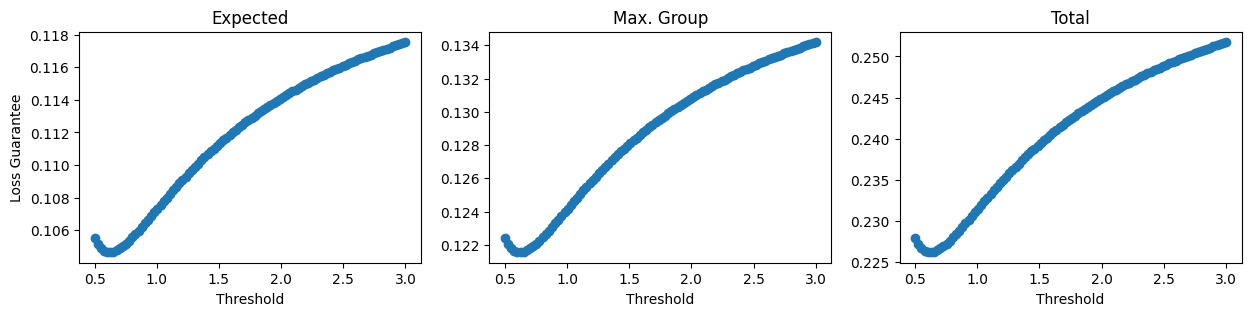

In [21]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1,3) 

ax[0].scatter(thresholds, full_aucs)
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Loss Guarantee")
ax[0].set_title("Expected")

ax[1].scatter(thresholds, group_diff)
ax[1].set_xlabel("Threshold")
ax[1].set_title("Max. Group")

ax[2].scatter(thresholds, total_loss)
ax[2].set_xlabel("Threshold")
ax[2].set_title("Total")

plt.show()

In [22]:
print("guarantee:", best_guar, "| actual:", actual_loss)

guarantee: 0.2262054979801178 | actual: 0.13437153212726116
